In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('amazon_clean4.csv')

In [3]:
df =df.dropna()

In [4]:
df.head()

,product_title,star_rating,review_body
0,Madden NFL 16 - Xbox One Digital Code,2,I keep buying madden every year hoping they ge...
1,Command & Conquer The Ultimate Collection [Ins...,5,If you are prepping for the end of the world t...
2,Sims 4,4,"i like the new skills like herbalism in this, ..."
3,Sid Meier's Civilization V,1,"As has been written by so many others, I quick..."
4,Build-a-lot 4: Power Source [Download],5,Probably the best game for learning aspects of...


## Topic Model: NMF with CountVectorizer

In [5]:
docs = df['review_body'].values

In [6]:
docs_label = [i[:30]+"..." for i in docs]

In [7]:
STOP = stopwords.words('english')
STOP += ['one', 'even', 'city', 'sim', 'sims', 'simcity', 'cities', 'really', 'would', 'lot', 'playing', 'many', 'sonic', 'however', 'still', 'since', 'ever', 'way', 'use', 'played', 'also', 'cdata', 'game', 'games', 'windows', 'object', 'video', 'ps']

In [8]:
vectorizer = CountVectorizer(stop_words=STOP, lowercase=True, token_pattern = r'(?u)\b[A-Za-z]+\b')
doc_word = vectorizer.fit_transform(docs)

In [9]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(doc_word)

In [10]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [11]:
display_topics(nmf_model, vectorizer.get_feature_names(), 40)


Topic  0
story, well, first, much, level, character, world, make, combat, find, characters, player, system, different, two, gameplay, around, though, enemies, end, go, could, things, see, experience, pretty, weapons, back, right, take, want, people, another, bit, made, times, every, actually, enough, may

Topic  1
amazon, download, steam, code, buy, origin, work, account, card, install, purchase, product, bought, version, xbox, got, pc, online, downloaded, computer, ea, live, go, problem, software, money, support, key, purchased, first, digital, never, run, price, service, tried, downloading, worked, could, update

Topic  2
play, online, ea, want, player, able, servers, server, hours, people, pc, mode, single, computer, players, internet, version, multiplayer, money, friends, free, issues, bought, could, graphics, love, connection, day, origin, first, start, without, know, enjoy, offline, work, years, make, always, drm

Topic  3
like, feel, much, people, think, things, better, see, ba

In [12]:
H = pd.DataFrame(doc_topic.round(5),
             index = docs_label,
             columns = ["game_content", "download", "online", "critique", "negative_feedback", "positive_feeback", "dlc", "worthwhile", "difficulty", "performance"])

In [13]:
rating = df['star_rating']
product_title = df['product_title']

H = H.reset_index().join(rating)
H = H.join(product_title)
H.head()

,index,game_content,download,online,critique,negative_feedback,positive_feeback,dlc,worth_time,difficulty,performance,star_rating,product_title
0,I keep buying madden every yea...,0.02187,0.03380,0.17537,0.05217,0.10315,0.06041,0.02644,0.00387,0.00185,0.00393,2,Madden NFL 16 - Xbox One Digital Code
1,If you are prepping for the en...,0.01966,0.00000,0.00000,0.00000,0.00000,0.05285,0.00237,0.00000,0.00000,0.00000,5,Command & Conquer The Ultimate Collection [Ins...
2,i like the new skills like her...,0.00000,0.00000,0.00000,0.12526,0.00000,0.00000,0.10032,0.00000,0.04953,0.00000,4,Sims 4
3,As has been written by so many...,0.00000,0.01229,0.00337,0.00474,0.00087,0.00217,0.04573,0.00412,0.00000,0.05578,1,Sid Meier's Civilization V
4,Probably the best game for lea...,0.03207,0.00253,0.00253,0.00252,0.00000,0.00369,0.01170,0.00364,0.00197,0.00610,5,Build-a-lot 4: Power Source [Download]


## Rating Count Distribution per Game

In [14]:
rating_count = pd.DataFrame(H.groupby('product_title')['star_rating'].value_counts())
rating_count['count']=H.groupby('product_title')['star_rating'].value_counts()
rating_count = rating_count.drop(columns='star_rating')
rating_count = rating_count.reset_index()
rating_count['star_rating']=rating_count['star_rating'].astype(int)
rating_count.head()

,product_title,star_rating,count
0,007 Legends [Download],1,2
1,007 Legends [Download],3,2
2,007 Legends [Download],4,1
3,007 Legends [Download],5,1
4,1 Moment Of Time: Silentville [Download],1,1


In [41]:
# Average Game Rating
avg_rating = H[H['product_title']=='007 Legends [Download]'].star_rating.mean()
avg_rating

2.8333333333333335

<AxesSubplot:xlabel='star_rating', ylabel='count'>

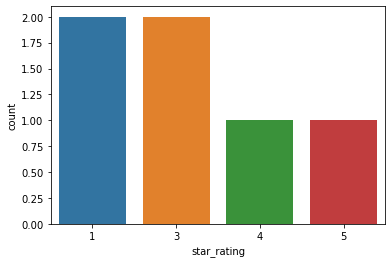

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

data1= rating_count[rating_count['product_title']=='007 Legends [Download]']
fig, ax = plt.subplots()
sns.barplot(data=data1, x='star_rating', y='count', ax=ax)

In [33]:
H.sort_values(by=['negative_feedback'], ascending=False).head(14)

,index,game_content,download,online,critique,negative_feedback,positive_feeback,dlc,worth_time,difficulty,performance,star_rating,product_title
104887,I finally broke down on impuls...,1.05501,0.00000,0.11093,0.69460,2.63986,0.46408,0.27348,0.64717,0.54436,0.11266,5,Guild Wars 2 Digital Deluxe [Online Game Code]
57284,"When your boss says to you \\""...",1.51058,0.25764,0.25010,0.73234,2.28890,0.00000,0.00000,0.73987,0.00000,0.27209,2,Faster Than Light
76163,"Weird thing, I love this game....",0.73062,0.01113,0.00000,0.75419,1.68362,0.00000,0.24470,0.70913,0.19622,0.76848,5,Far Cry 2
24040,The idea of a silly shooter in...,0.27609,0.00000,0.84822,0.15008,1.61261,0.00587,0.49809,0.42548,0.39472,0.37573,3,Plants vs. Zombies Garden Warfare
104470,I have been really enjoying gu...,1.67455,0.21868,0.00000,0.89249,1.52284,0.02364,0.32609,0.65339,0.00000,0.00000,5,Guild Wars 2 Digital Deluxe [Online Game Code]
81292,CONTENTS:1. The Bottom Line (I...,1.66261,0.27210,0.07265,0.42218,1.38541,0.13921,0.00000,1.32931,0.00666,0.43966,2,Tomb Raider
70446,"Overall, Might & Magic VI is a...",1.00301,0.24239,0.18636,0.80570,1.18409,0.00000,0.18198,0.33540,0.18989,0.27775,1,Might & Magic Heroes VI: Complete Edition [Dow...
79170,So quickest review: buy it.Lon...,0.56196,0.62057,0.11811,0.83707,1.17576,0.13281,2.60668,0.50257,0.35941,0.51316,5,Trainz Simulator 2009: World Builder Edition [...
41388,I found out about this game ov...,1.69438,0.00000,0.34936,0.49893,1.09120,0.00000,0.29719,0.65285,0.00000,0.29400,3,Final Fantasy XIV: A Realm Reborn
31653,"Being only 19 years old, I hav...",0.53953,0.01287,0.20002,0.45194,1.01601,0.59947,0.00000,0.04454,0.00000,0.12937,5,Wolfenstein: The New Order


In [34]:
H_new = H.set_index('index')
H_new.head()

,game_content,download,online,critique,negative_feedback,positive_feeback,dlc,worth_time,difficulty,performance,star_rating,product_title
index,,,,,,,,,,,,
I keep buying madden every yea...,0.02187,0.03380,0.17537,0.05217,0.10315,0.06041,0.02644,0.00387,0.00185,0.00393,2,Madden NFL 16 - Xbox One Digital Code
If you are prepping for the en...,0.01966,0.00000,0.00000,0.00000,0.00000,0.05285,0.00237,0.00000,0.00000,0.00000,5,Command & Conquer The Ultimate Collection [Ins...
i like the new skills like her...,0.00000,0.00000,0.00000,0.12526,0.00000,0.00000,0.10032,0.00000,0.04953,0.00000,4,Sims 4
As has been written by so many...,0.00000,0.01229,0.00337,0.00474,0.00087,0.00217,0.04573,0.00412,0.00000,0.05578,1,Sid Meier's Civilization V
Probably the best game for lea...,0.03207,0.00253,0.00253,0.00252,0.00000,0.00369,0.01170,0.00364,0.00197,0.00610,5,Build-a-lot 4: Power Source [Download]


In [35]:
H_new['star_rating'] = H_new['star_rating'].replace([1,2], 'negative')
H_new['star_rating'] = H_new['star_rating'].replace([4,5], 'positive')

In [36]:
H_avg = H_new.groupby('star_rating').mean()
H_avg.head()

,game_content,download,online,critique,negative_feedback,positive_feeback,dlc,worth_time,difficulty,performance
star_rating,,,,,,,,,,
3,0.024299,0.017523,0.026825,0.025414,0.022137,0.012709,0.014302,0.018529,0.019608,0.021303
negative,0.012217,0.032164,0.027411,0.014350,0.020896,0.005944,0.010124,0.016134,0.006602,0.009108
positive,0.014865,0.017437,0.018397,0.015557,0.015487,0.020480,0.010275,0.012673,0.016817,0.015026


Negative top Topics: download 0.029, online 0.027, negative_feedback 0.021, worth_time 0.016 <br>
Positive top Topics: positive_feedback 0.020, difficulty 0.020, online 0.019, performance 0.018, 

## Topic Distribution Per Game

In [38]:
H_new.loc[(H_new['product_title'] == 'Tropico 5') & (H_new['star_rating'] == 'positive')].mean().sort_values(ascending=False)

dlc                  0.051499
difficulty           0.042448
critique             0.031591
game_content         0.030642
online               0.027576
worth_time           0.024955
negative_feedback    0.023839
positive_feeback     0.020646
performance          0.013785
download             0.009984
dtype: float64

In [39]:
H_new.loc[(H_new['product_title'] == 'Tropico 5') & (H_new['star_rating'] == 'negative')].mean().sort_values(ascending=False)

download             0.031982
online               0.021991
negative_feedback    0.018361
performance          0.006739
game_content         0.006161
critique             0.004931
dlc                  0.004719
positive_feeback     0.001438
worth_time           0.001383
difficulty           0.000649
dtype: float64